# Vector Space Models

In [2]:
from nltk.corpus import brown
import re
from scipy import sparse

## Converting Documents to Vectors

In [103]:
# load text files
docs = list(brown.files())[:500]
texts = [None]*len(docs)
for i,doc in enumerate(docs):
    with brown.open(doc) as stream:
        texts[i] = brown.words(fileids=[doc])
# linguistic processing
for i,t in enumerate(texts):
    texts[i] = [re.sub('(s|ing)$','',w.lower()) for w in t]
# dictionary construction
dictionary = sorted(list(set([w for t in texts for w in t])))
wids = {w:i for i,w in enumerate(dictionary)}
for i,t in enumerate(texts):
    texts[i] = [wids[w] for w in t]

In [104]:
A = sparse.lil_matrix((len(docs),len(wids.keys())))

In [105]:
for d,t in enumerate(texts):
    for w in t:
        A[d,w] += 1

In [106]:
A = A.tocsr()

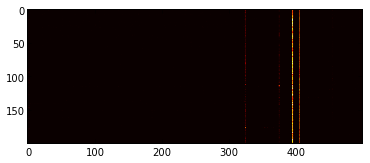

In [107]:
imshow(A[:200,:500].todense(),cmap=cm.hot)

In [108]:
B = dot(A,A.T)

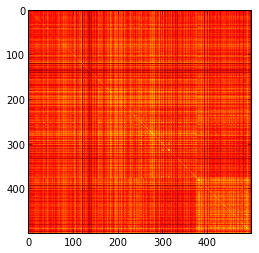

In [109]:
imshow(log(1+B.todense()),cmap=cm.hot)

In [110]:
As = A
A = array(As.todense())

In [111]:
A.shape

(500, 43259)

## TF-IDF

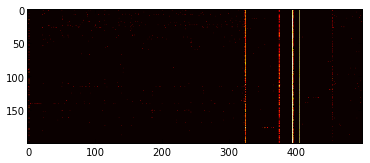

In [114]:
tf = log(1+A)
imshow(tf[:200,:500],cmap=cm.hot)

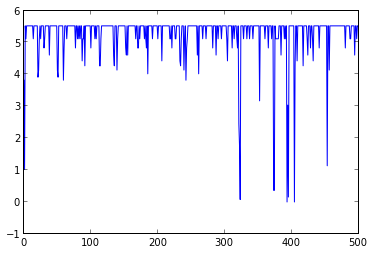

In [119]:
idf = log(len(A)/(1.0+sum(A>0,axis=0)))
plot(idf[:500])

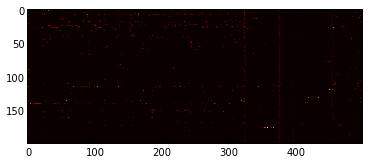

In [121]:
tfidf = tf * idf[newaxis,:]
imshow(tfidf[:200,:500],cmap=cm.hot)

## Vector Space Retrieval with Weight Vector

Once we have an array of term frequencies or TF-IDF scores, we can use it to perform scoring using dot products.

This isn't just idle experimentation; the representation as vectors and dot products opens up a number of possibilities:

- we can use efficient sparse matrix packages for representing documents and queries
- we can take advantage of efficient numerical codes
- we can perform linear algebraic operation on the data
- we can use this data as input to pattern recognition algorithms

We construct a query vector like this. Here, the query uses equal weights for the terms, but we could use different weights for each term.

In [131]:
weights = zeros(A.shape[1])
weights[wids["operation"]] = 1
weights[wids["degree"]] = 1
weights[wids["find"]] = 1

### Boolean Queries with Dot Products

Now to find the total number of query terms in each document, we compute this dot product.
Note that we threshold the term frequency matrix `A>0` because we only want to add
a score of `1` for each term occurrence.

In [139]:
scores = dot(A>0,weights)
-sort(-scores)[:10]

array([ 3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.])

In [140]:
argsort(-scores)[:10]

array([366, 153, 329, 482, 104, 409, 111, 269, 124, 281])

We can actually use this for a conjunctive query; this is the list of documents in which all three query terms occur.

In [141]:
find(scores==3)

array([ 66, 104, 111, 124, 125, 153, 269, 281, 329, 353, 366, 409, 482])

### Term Frequencies as Scores

We can perform the same computation using the term frequency matrix for scoring.

In [135]:
scores = dot(A,weights)
-sort(-scores)[:10]

array([ 10.,  10.,  10.,   9.,   8.,   8.,   8.,   7.,   7.,   7.])

In [136]:
argsort(-scores)[:10]

array([267, 372, 286,  25, 232, 311, 134, 179, 467, 133])

As noted before, this is not such a good idea, because terms like "the" or "have" get too much weight.

### TF-IDF Vectors

In [123]:
print [(x,dictionary[x]) for x in argsort(-sum(tfidf,axis=0))[:20]]

[(34798, 'she'), (1, '!'), (18802, 'her'), (43145, 'you'), (2274, '?'), (25820, 'mr.'), (24575, 'me'), (26046, 'my'), (43160, 'your'), (2876, 'af'), (36717, 'state'), (30599, 'program'), (33500, 'said'), (33913, 'school'), (27801, 'our'), (19033, 'him'), (17444, 'government'), (453, '1'), (41985, 'water'), (38016, 'system')]


In [124]:
weights = zeros(A.shape[1])
weights[wids["operation"]] = 1
weights[wids["degree"]] = 1
weights[wids["find"]] = 1

In [125]:
scores = dot(A,weights)

In [126]:
print scores[:100]

[ 2.  4.  0.  2.  1.  3.  1.  1.  1.  0.  1.  1.  0.  1.  0.  0.  0.  1.
  4.  0.  1.  1.  2.  2.  0.  9.  1.  1.  0.  1.  2.  1.  0.  1.  2.  0.
  1.  0.  0.  0.  1.  0.  6.  2.  0.  3.  0.  2.  0.  0.  1.  2.  1.  1.
  2.  1.  1.  3.  1.  0.  2.  3.  0.  0.  0.  2.  3.  0.  2.  3.  2.  2.
  0.  1.  0.  1.  2.  1.  0.  0.  0.  0.  1.  2.  0.  3.  0.  4.  4.  0.
  2.  1.  3.  0.  2.  2.  3.  1.  4.  2.]


In [127]:
argsort(scores)[:10]

array([499, 419, 149, 150, 151, 157, 159, 406, 165, 403])

## Document Similarity and Dot Products

The above considerations have been motivated by the idea of "querying" a database: looking for documents containing terms.

We can also view documents as objects whose similarity we want to determine.

In principle, we might try to say something like: documents are similar if their term vectors $v$ and $w$ are similar.

We usually measure vector similarity as Euclidean distance $||v-w||$

This turns out not to be such a good idea in general, since the TF-IDF scores are not normalized vectors; if one document is a lot longer than the other, it gets a larger score, even though they may both be basically "the same" text.


In [130]:
lengths = sum(tfidf**2,axis=0)**.5
amin(lengths),amax(lengths)

(0.093446482673695874, 41.327106487837028)

A more common form of determining similarity is therefore the normalized dot product or "correlation".

In [150]:
norm_tfidf = tfidf/(sum(tfidf**2,axis=1)**.5)[:,newaxis]
sum(norm_tfidf**2,axis=1)[:10]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [152]:
similarities = dot(norm_tfidf,norm_tfidf.T)

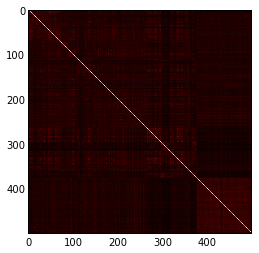

In [156]:
imshow(similarities,cmap=cm.hot)

In [157]:
fill_diagonal(similarities,0)

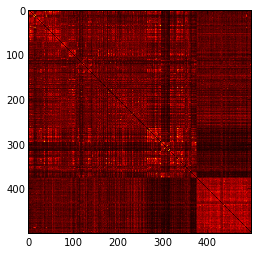

In [158]:
imshow(similarities,cmap=cm.hot)

Once we view dot products as determining document similarity, we can return and ask what our "weighted queries" mean.  We can think of them in one of two ways:

- a query is a small document that is a "sample" from the same distribution as the original document

- a query represents a large document, but we perform the dot product in a subspace corresponding to relevant terms

The second view is usually the better one.

Note again the dimensionalities of vectors and documents:

In [181]:
tfidf.shape

(500, 43259)

We are dealing with a very high dimensional space and a small number of samples.
This problem is similar to what we have in kernel-based learning methods.

Generally, we can make operations more efficient by "kernelizing" out dot products and performing all the operations in document space instead of the original feature space.